In [2]:
!unzip val.zip

Archive:  val.zip
   creating: val/
  inflating: val/VizWiz_val_00004462.jpg  
  inflating: val/VizWiz_val_00001933.jpg  
  inflating: val/VizWiz_val_00005103.jpg  
  inflating: val/VizWiz_val_00003094.jpg  
  inflating: val/VizWiz_val_00004132.jpg  
  inflating: val/VizWiz_val_00001288.jpg  
  inflating: val/VizWiz_val_00003226.jpg  
  inflating: val/VizWiz_val_00002319.jpg  
  inflating: val/VizWiz_val_00004068.jpg  
  inflating: val/VizWiz_val_00002975.jpg  
  inflating: val/VizWiz_val_00000973.jpg  
  inflating: val/VizWiz_val_00002931.jpg  
  inflating: val/VizWiz_val_00000213.jpg  
  inflating: val/VizWiz_val_00001771.jpg  
  inflating: val/VizWiz_val_00000617.jpg  
  inflating: val/VizWiz_val_00002095.jpg  
  inflating: val/VizWiz_val_00007503.jpg  
  inflating: val/VizWiz_val_00004027.jpg  
  inflating: val/VizWiz_val_00004952.jpg  
  inflating: val/VizWiz_val_00004873.jpg  
  inflating: val/VizWiz_val_00004468.jpg  
  inflating: val/VizWiz_val_00005128.jpg  
  inflating: val/V

In [127]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt


# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
annotation_t='annotations/train.json'
annotation_v='annotations/val.json'

In [3]:
PATH=os.path.abspath('.')

In [39]:
annotations_v

{'annotations': [{'caption': 'A computer screen shows a repair prompt on the screen.',
   'id': 117155,
   'image_id': 23431,
   'is_precanned': False,
   'is_rejected': False,
   'text_detected': True},
  {'caption': 'a computer screen with a repair automatically pop up',
   'id': 117156,
   'image_id': 23431,
   'is_precanned': False,
   'is_rejected': False,
   'text_detected': True},
  {'caption': 'partial computer screen showing the need of repairs',
   'id': 117157,
   'image_id': 23431,
   'is_precanned': False,
   'is_rejected': False,
   'text_detected': True},
  {'caption': 'Part of a computer monitor showing a computer repair message.',
   'id': 117158,
   'image_id': 23431,
   'is_precanned': False,
   'is_rejected': False,
   'text_detected': True},
  {'caption': 'The top of a laptop with a blue background and dark blue text.',
   'id': 117159,
   'image_id': 23431,
   'is_precanned': False,
   'is_rejected': False,
   'text_detected': True},
  {'caption': 'A person is hol

In [128]:
with open(annotation_t, 'r') as f:
    annotations_t = json.load(f)
    
with open(annotation_v, 'r') as f:
    annotations_v = json.load(f)

mapping=dict()
# Store captions and image names in vectors
all_captions_t = []
all_img_name_vector_t= []
all_captions_v = []
all_img_name_vector_v= []

for annot in annotations_t['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    
    full_image_path = PATH + '/train/VizWiz_train_' + '%08d.jpg' % (image_id)
    
    all_img_name_vector_t.append(full_image_path)
    all_captions_t.append(caption)
    
for annot in annotations_v['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']-23431
    if(caption=='Quality issues are too severe to recognize visual content.'):
        if(image_id in mapping):
            mapping.pop(image_id)
        continue
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption.split(' '))
    full_image_path = PATH + '/val/VizWiz_val_' + '%08d.jpg' % (image_id)
    #print(full_image_path)
    all_img_name_vector_v.append(full_image_path)
    all_captions_v.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions_t,
                                          all_img_name_vector_t,
                                          random_state=1)
val_captions,val_img=all_captions_v,all_img_name_vector_v
all_captions=[]
all_captions=all_captions_t
all_captions.append(all_captions_v)


In [129]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [130]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [131]:
# Get unique images
encode_train = sorted(set(img_name_vector))
encode_val=sorted(set(val_img))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)



In [132]:
image_dataset_v = tf.data.Dataset.from_tensor_slices(encode_val)
image_dataset_v = image_dataset_v.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)


In [61]:
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [91]:
for img, path in image_dataset_v:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [8]:
%load_ext tensorboard

In [9]:
itr=image_dataset.__iter__()

In [10]:
sample=next(itr)

In [11]:
sample[0][0]

<tf.Tensor: id=2057269, shape=(299, 299, 3), dtype=float32, numpy=
array([[[ 0.7443931 ,  0.43095517,  0.06211901],
        [ 0.6380353 ,  0.37242115,  0.05841684],
        [ 0.26617992,  0.03088582, -0.25468248],
        ...,
        [ 0.73242795,  0.21478093, -0.45972896],
        [ 0.76647246,  0.24600577, -0.40435904],
        [ 0.885003  ,  0.35595787, -0.24514216]],

       [[ 0.6992526 ,  0.40221322,  0.15122294],
        [ 0.519266  ,  0.2513504 ,  0.02526653],
        [ 0.11058879, -0.12103301, -0.359147  ],
        ...,
        [ 0.8576175 ,  0.33212733, -0.28964835],
        [ 0.77798426,  0.2578845 , -0.35633278],
        [ 0.8220383 ,  0.3008269 , -0.29682183]],

       [[ 0.68306506,  0.393386  ,  0.16438389],
        [ 0.4898708 ,  0.22394586, -0.0108214 ],
        [ 0.15167415, -0.09123218, -0.33748925],
        ...,
        [ 0.8615507 ,  0.36743307, -0.24800432],
        [ 0.81659424,  0.3023703 , -0.2948491 ],
        [ 0.7613106 ,  0.24594557, -0.34177536]],

      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


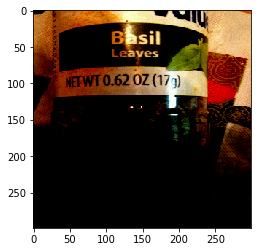

In [12]:
%matplotlib inline
plt.imshow(sample[0][0])

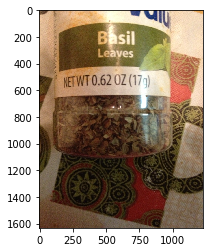

In [13]:
imgg=plt.imread(encode_train[0])
plt.imshow(imgg)

In [66]:
all_captions

['<start> ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO. <end>',
 '<start> A green and white plastic condiment bottle containing Basil leaves. <end>',
 '<start> Quality issues are too severe to recognize visual content. <end>',
 '<start> A bottle of spices in a plastic container laying on a surface. <end>',
 '<start> some basil leaves in a container on a counter <end>',
 '<start> A can of Coca Cola on a counter is shown for when one can use a nice, cold drink. <end>',
 '<start> A black can of Coca Cola Zero calorie soda is on the counter near the coffee maker. <end>',
 '<start> A kitchen counter the various items on top including a can of Coca-Cola, metal containers, and a teapot. <end>',
 '<start> a black tin of Coca Cola placed on a black surface <end>',
 '<start> Black counter with canisters, kettle and can of soda. <end>',
 '<start> A can of crushed tomatoes are on a brown surface, the tomatoes read crushed tomatoes on the brand. <end>',
 '<start> A can of crushed

In [133]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [134]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [95]:
val_seqs=tokenizer.texts_to_sequences(val_captions)
val_cc=tokenizer.tokenize(val_captions)

AttributeError: 'Tokenizer' object has no attribute 'tokenize'

In [135]:
 tokenizer.word_index #made vocabulary


{'kha': 9580,
 'nhm': 16291,
 'stylist': 15347,
 'tangle': 10500,
 'maranatha': 16024,
 'schwartz': 7623,
 'government': 4359,
 'or': 56,
 'shoeless': 17665,
 'thermo': 9642,
 'bare': 1277,
 'stump': 6864,
 "food's": 7635,
 'fantasia': 12723,
 'ex': 15912,
 'goldberg': 8074,
 'indecipherable': 15365,
 'black': 23,
 'offs': 16957,
 "nature's": 4706,
 'triangular': 2886,
 'quoted': 14756,
 '1029649': 11904,
 'flagpole': 16668,
 'hairless': 5759,
 'guitar': 921,
 'woman’s': 16191,
 'kilohertz': 14521,
 'steams': 15048,
 'toothbrushes': 18031,
 'groin': 17293,
 'seuss': 5229,
 'life—': 15441,
 'saints': 10472,
 'fluid': 1882,
 'embarrassed': 10091,
 'separates': 8952,
 'wholefoods': 17513,
 'northeastern': 18107,
 'verbatim': 10267,
 "cadbury's": 11529,
 'awards': 10027,
 'funky': 11346,
 '373': 15318,
 'contest': 6958,
 "printer's": 9952,
 'worker': 9693,
 'emperor': 6826,
 'fiesta': 2389,
 "'51'": 15298,
 'dan': 11954,
 'common': 5828,
 'penzeys': 18118,
 'guy': 1913,
 'dreamcast': 9897,

In [136]:
tokenizer.word_index['<pad>']=0
tokenizer.word_index[0]='<pad>'

In [137]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [138]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
cap_vector_v=tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')

In [139]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [140]:
# Create training and validation sets 
img_name_train,  cap_train = img_name_vector, cap_vector
                                                                    
img_name_val, cap_val=val_img,cap_vector_v

In [141]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(117155, 117155, 38750, 38750)

In [142]:
# Feel free to change these parameters according to your system's configuration
top_k=5000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [143]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [144]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [145]:
dataset_val=tf.data.Dataset.from_tensor_slices((img_name_val,cap_val))
dataset_val = dataset_val.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
#dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(1)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [39]:
next(iter(dataset_val))

(<tf.Tensor: id=90297, shape=(64, 2048), dtype=float32, numpy=
 array([[0.5326499 , 0.43709362, 1.287098  , ..., 0.28836435, 0.        ,
         0.5655846 ],
        [0.        , 0.        , 0.34336329, ..., 0.24831356, 0.        ,
         0.00756095],
        [0.        , 0.        , 0.        , ..., 0.14754553, 0.        ,
         0.        ],
        ...,
        [0.26266244, 0.        , 1.3177121 , ..., 1.8910215 , 0.06454858,
         0.44306612],
        [0.        , 0.        , 1.9574752 , ..., 1.5548248 , 0.        ,
         0.48743224],
        [0.        , 0.        , 2.367291  , ..., 1.1445796 , 0.        ,
         0.51836276]], dtype=float32)>,
 <tf.Tensor: id=90298, shape=(157,), dtype=int32, numpy=
 array([   3,    2,   55,   50,  160,    2, 1079, 1258,    6,    7,   50,
           4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

In [146]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [147]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [148]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [149]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [150]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [151]:
checkpoint_path = "./checkpoints/train/last"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [152]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [153]:
start_epoch


0

In [154]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [164]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
 # result=[]
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          print("d")
          loss += loss_function(target[:, i], predictions)
          #predicted_id = tf.random.categorical(predictions, 64)[0][0].numpy()
          #result.append(predicted_id)
          #print(loss)
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  #print(total-loss)
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [156]:
start_epoch


0

In [165]:
 #total epochs done= 7
EPOCHS = 3

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        print("dd")
#         print("nkk")
#         print(target,target.shape)
       # print(batch_loss.shape,t_loss.shape)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            #print(batch_loss,total_loss)
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
dd
Epoch 1 Batch 0 Loss 1.0610
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
Epoch 1 Batch 50 Loss 0.6007
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
Epoch 1 Batch 100 Loss 0.4945
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
dd
Epoc

In [161]:
target

<tf.Tensor: id=36441649, shape=(64, 115), dtype=int32, numpy=
array([[  3, 780, 337, ...,   0,   0,   0],
       [  3,  16,  20, ...,   0,   0,   0],
       [  3,   2,  57, ...,   0,   0,   0],
       ...,
       [  3,  97, 108, ...,   0,   0,   0],
       [  3,  97,   1, ...,   0,   0,   0],
       [  3,  45,   5, ...,   0,   0,   0]], dtype=int32)>

In [97]:
target.shape

TensorShape([64, 115])

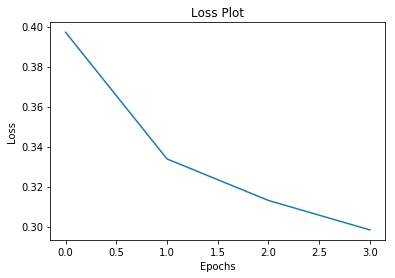

In [88]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [44]:
from nltk.translate.bleu_score import corpus_bleu
def evaluatll(image,target):
    #attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

#     temp_input = tf.expand_dims(load_image(image)[0], 0)
#     img_tensor_val = image_features_extract_model(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(image)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    #print(dec_input.shape[0])
    result = ['<start>']
    loss=0;
    lenn=1;
    
    for i in range(max_length):
        #print(result)
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        lenn+=1;
        #if(i<=target.shape[0]):
        loss += loss_function(target[i], predictions)
#         print(target[i],predictions)
#         print("loss=")
#         print(loss)
        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
           # print(loss/lenn)
            return result, loss/ max_length
        

        dec_input = tf.expand_dims([predicted_id], 0)
    #loss=loss/
    #total_loss = (loss / int(target.shape[1]))
    #attention_plot = attention_plot[:len(result), :]
   # print(loss/lenn)
    return result,loss/ max_length

In [168]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = ['<start>']

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [170]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    
    fig = plt.figure(figsize=(20, 20))

    len_result = len(result)
    for l in range(1,len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [54]:
target.shape[0]

NameError: name 'target' is not defined

Batch 0 Loss 0.8187 Blu score0.269855346668251
<start> a computer screen which is placed on a screen <end> [['<start>', 'A', 'computer', 'screen', 'shows', 'a', 'repair', 'prompt', 'on', 'the', 'screen.', '<end>'], ['<start>', 'a', 'computer', 'screen', 'with', 'a', 'repair', 'automatically', 'pop', 'up', '<end>'], ['<start>', 'partial', 'computer', 'screen', 'showing', 'the', 'need', 'of', 'repairs', '<end>'], ['<start>', 'Part', 'of', 'a', 'computer', 'monitor', 'showing', 'a', 'computer', 'repair', 'message.', '<end>'], ['<start>', 'The', 'top', 'of', 'a', 'laptop', 'with', 'a', 'blue', 'background', 'and', 'dark', 'blue', 'text.', '<end>']]
Batch 100 Loss 0.7991 Blu score7.57965434483665e-155
<start> windows mouse is on front of a sign <end> [['<start>', 'point', 'of', 'sale', 'food', 'or', 'deli', 'possibly', 'inside', 'of', 'the', 'mall', 'or', 'other', 'retail', 'outlet.', '<end>'], ['<start>', 'GLOOMY', 'SNAPSHOT', 'OF', 'A', 'SNACK', 'BAR', 'SITE', '<end>'], ['<start>', 'Some'

KeyboardInterrupt: 

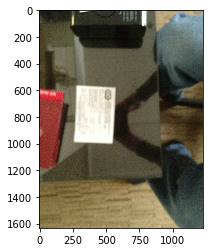

In [103]:
from torchtext.data.metrics import bleu_score
from nltk.translate.bleu_score import sentence_bleu
%matplotlib inline
total_loss=0
bl_scr=0;
reference=[]
candidate=[]
for (batch, (img_tensor, target)) in enumerate(dataset_val):
#img_tensor=next(intnext(iter(dataset_val))
    if int(batch/5) not in mapping :
        continue
    result, t_loss = evaluatll(img_tensor, target)
    #blu=bleu_score([result],[mapping[0]],weights=(0.25, 0.25, 0.25, 0.25))
    reference = mapping[int(batch/5)]
    candidate = result
    #print(' '.join(candidate),' '.join(result))
    score = sentence_bleu(reference, candidate)
    #print(score,reference,candidate)
    #print(t_loss,' '.join(result))
    #plt.imshow(img_tensor)
    if(batch%100==0):
        print ('Batch {} Loss {:.4f} Blu score{}'.format(
             batch, t_loss.numpy() ,score))
        print(' '.join(result),mapping[int(batch/5)])
        plt.imshow(plt.imread(val_img[int(batch/5)]))
    total_loss += t_loss
    bl_scr+=score
    #plt.imshow(plt.imread(val_img[0]))
    #print(plt.imread(val_img[0]))
    #plt.imshow(img_tensor)
    

    #if batch % 100 == 0:
           # print ('Epoch {} Batch {} Loss {:.4f}'.format(
           #   epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    #loss_plot.append(total_loss / num_steps)
print(total_loss/len(img_name_val))
print(bl_scr/len(img_name_val))

In [196]:
reference=[]
candidate=[]
score=0

for i in range(0,len(encode_val)):
    result,_=evaluate(encode_val[i])
    reference.append(mapping[i])
    candidate.append(result)
    score += sentence_bleu(mapping[i], result)
    #f.write(encode_val,)
    if(i%50==0):
        print(encode_val[i])
        print(result,mapping[i])
    
print(score/len(encode_val))


/home/user2/.local/lib/python3.5/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


/home/user2/Captioning_ImgsBlind/val/VizWiz_val_00000000.jpg
['<start>', 'a', 'computer', 'system', 'operating', 'system', 'next', 'to', 'an', 'app', 'processor', 'it', 'looks', 'like', 'a', 'startup', 'repair', 'window', 'giving', 'the', 'computer', 'prompt', 'dialog', 'boxes', 'open', 'error', 'message', '<end>'] [['<start>', 'A', 'computer', 'screen', 'shows', 'a', 'repair', 'prompt', 'on', 'the', 'screen.', '<end>'], ['<start>', 'a', 'computer', 'screen', 'with', 'a', 'repair', 'automatically', 'pop', 'up', '<end>'], ['<start>', 'partial', 'computer', 'screen', 'showing', 'the', 'need', 'of', 'repairs', '<end>'], ['<start>', 'Part', 'of', 'a', 'computer', 'monitor', 'showing', 'a', 'computer', 'repair', 'message.', '<end>'], ['<start>', 'The', 'top', 'of', 'a', 'laptop', 'with', 'a', 'blue', 'background', 'and', 'dark', 'blue', 'text.', '<end>']]


/home/user2/.local/lib/python3.5/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user2/.local/lib/python3.5/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


/home/user2/Captioning_ImgsBlind/val/VizWiz_val_00000050.jpg
['<start>', 'dryer', '<end>'] [['<start>', 'Screenshot', 'of', 'an', 'electronic', 'device', 'showing', 'a', 'list', 'of', 'media', 'categories.', '<end>'], ['<start>', 'A', 'blurry', 'image', 'of', 'the', 'digital', 'screen', 'of', 'a', 'digital', 'camera.', '<end>'], ['<start>', 'the', 'option', 'menu', 'of', 'a', 'black', 'Olympus', 'cell', 'phone', '<end>'], ['<start>', 'A', 'phone', 'showing', 'its', 'menu', 'settings', 'in', 'white', 'lettering', '<end>'], ['<start>', 'Quality', 'issues', 'are', 'too', 'severe', 'to', 'recognize', 'visual', 'content.', '<end>']]
/home/user2/Captioning_ImgsBlind/val/VizWiz_val_00000100.jpg
['<start>', 'a', 'white', 'food', 'package', 'of', 'some', 'chocolates', 'with', 'a', 'soda', 'can', 'of', 'some', 'sort', 'of', 'paint', '<end>'] [['<start>', 'Quality', 'issues', 'are', 'too', 'severe', 'to', 'recognize', 'visual', 'content.', '<end>'], ['<start>', 'Quality', 'issues', 'are', 'too', 

In [194]:
f=open("predic.txt",'w')
f.writelines(candidate)

TypeError: write() argument must be str, not list

In [74]:
# captions on the validation set
loss=0
#for rid in range(len(img_name_val)):
#rid = np.random.randint(0, len(img_name_val))

image = img_name_val[rid]
i
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
predicted_caption=' '.join(result)
#tot_loss+=loss
    
# tot_loss=loss/len(img_name_val)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plt.imshow(plt.imread(image))
plot_attention(image, result, attention_plot)


NameError: name 'i' is not defined

1300 /home/user2/Captioning_ImgsBlind/val/VizWiz_val_00001300.jpg
[['<start>', 'A', 'blank', 'piece', 'of', 'white', 'paper', 'being', 'held.', '<end>'], ['<start>', 'A', 'person', 'is', 'holding', 'up', 'a', 'blank', 'sheet', 'of', 'folded', 'paper.', '<end>'], ['<start>', 'A', 'white', 'piece', 'of', 'paper', 'that', 'has', 'been', 'folded', 'but', 'has', 'nothing', 'on', 'it.', '<end>'], ['<start>', 'A', 'piece', 'of', 'white', 'paper', 'that', 'has', 'been', 'folded', 'into', 'thirds', 'and', 'then', 'unfolded', 'and', 'held', 'up.', '<end>'], ['<start>', 'Blank', 'piece', 'of', 'paper', 'with', 'creases', 'from', 'having', 'been', 'folded', 'into', 'thirds', 'horizontally.', '<end>']]
Prediction Caption: <start> a white paper with a check on it <end>


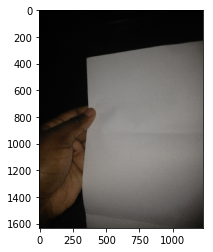

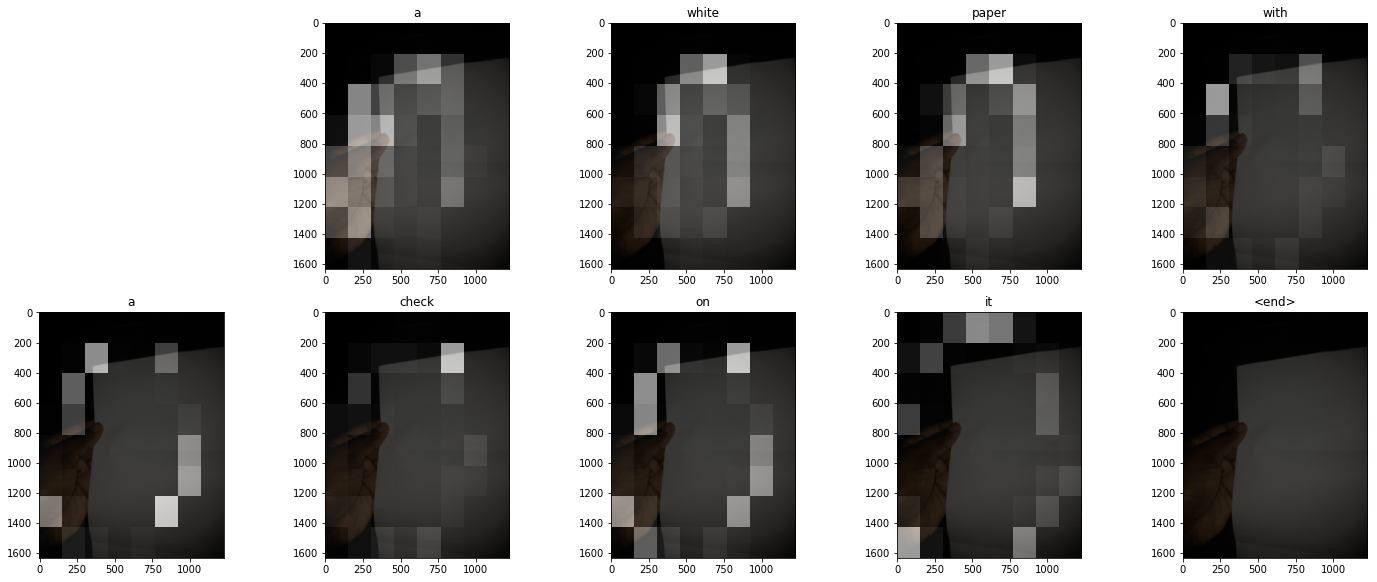

In [285]:
# captions on the validation set
loss=0
#for rid in range(len(img_name_val)):
#rid = np.random.randint(0, len(encode_val))
rid=1300
image = encode_val[rid]
print(rid,image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
predicted_caption=' '.join(result)
#tot_loss+=loss
    
# tot_loss=loss/len(img_name_val)

#print ('Real Caption:', real_caption)
print(mapping[rid])
print ('Prediction Caption:', ' '.join(result))
plt.imshow(plt.imread(image))
plot_attention(image, result, attention_plot)
#2321 2315

In [182]:
cap_val

array([[   3,    2,   55, ...,    0,    0,    0],
       [   3,    2,   55, ...,    0,    0,    0],
       [   3,  315,   55, ...,    0,    0,    0],
       ...,
       [   3,   30, 2518, ...,    0,    0,    0],
       [   3,   30, 2518, ...,    0,    0,    0],
       [   3,    2,  702, ...,    0,    0,    0]], dtype=int32)

In [94]:

from nltk.translate.bleu_score import sentence_bleu
reference =[ list([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])]
candidate = result
#print(' '.join(reference),' '.join(result))
score = sentence_bleu(reference, candidate)
print(score)

1.0


In [81]:

from nltk.translate.bleu_score import sentence_bleu
reference = mapping[0]
candidate = result
#print(' '.join(reference),' '.join(result))
score = sentence_bleu(reference, candidate)
print(score,reference,candidate)

0.3945881255591767 [['<start>', 'A', 'computer', 'screen', 'shows', 'a', 'repair', 'prompt', 'on', 'the', 'screen.', '<end>'], ['<start>', 'a', 'computer', 'screen', 'with', 'a', 'repair', 'automatically', 'pop', 'up', '<end>'], ['<start>', 'partial', 'computer', 'screen', 'showing', 'the', 'need', 'of', 'repairs', '<end>'], ['<start>', 'Part', 'of', 'a', 'computer', 'monitor', 'showing', 'a', 'computer', 'repair', 'message.', '<end>'], ['<start>', 'The', 'top', 'of', 'a', 'laptop', 'with', 'a', 'blue', 'background', 'and', 'dark', 'blue', 'text.', '<end>']] ['<start>', 'a', 'computer', 'screen', 'with', 'agreement', 'restore', 'displaying', 'the', 'repair', '<end>']


In [166]:
from nltk.translate.bleu_score import corpus_bleu
def evaluatbl(image):
    #attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(image)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    #print(dec_input.shape[0])
    result = ['<start>']
    loss=0;
    lenn=1;
    
    for i in range(max_length):
        #print(result)
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        lenn+=1;
        #if(i<=target.shape[0]):
        #loss += loss_function(target[i], predictions)
#         print(target[i],predictions)
#         print("loss=")
#         print(loss)
        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
           # print(loss/lenn)
            return result
        

        dec_input = tf.expand_dims([predicted_id], 0)
    #loss=loss/
    #total_loss = (loss / int(target.shape[1]))
    #attention_plot = attention_plot[:len(result), :]
   # print(loss/lenn)
    return result

In [68]:
print(loss)

tf.Tensor(3.9850366, shape=(), dtype=float32)
